# Multinomial regression

In this notebook we perform multinomial / softmax resression

In [4]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from Code.utilities import MSELoss_method, plot_test_results, cross_entropy_loss_method, predict, accuracy_func
from Code.neural_network import _beta_init, get_neural_network_model
from Code.descent_methods import SGD_adam
from Code.data_handling import load_MNIST_28, append_run_to_file, load_run_from_file
from Code.softmax_regression import softmax, softmax_beta_init, softmax_model

from jax import jit, nn, grad
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

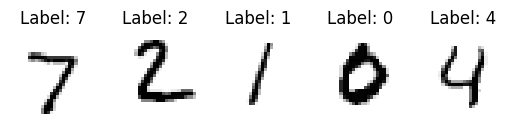

In [2]:
# download MNIST dataset
X_train, y_train, X_test, y_test = load_MNIST_28(flatten_images=True)

# Display some images
for i, image in enumerate(X_test[0:5]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    n = int((image.shape[0])**(1/2))
    plt.imshow(image.reshape(n,n), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f"Label: {np.argmax(y_test[i])}")
plt.show()

### Single run

100%|██████████| 50/50 [00:50<00:00,  1.00s/it]


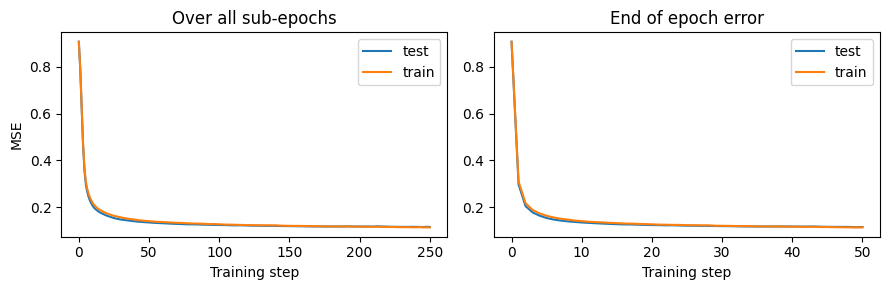

test:  0.9240000247955322
train:  0.927383303642273


In [11]:
def single_run(X_train, X_test, y_train, y_test, 
               lr, lam, epochs=300, batches=5,
               plot_or_not=False, result_filepath=None):
    """
    Performs a training with the given parameters

    Returns result, including the final accuracy scores
    """

    # Initialise beta and create the model
    beta0 = softmax_beta_init(input_shape=X_train.shape[1], output_shape=y_train.shape[1])
    model = softmax_model

    # Create gradient from loss function. Ridge loss lets us use MSE by lam=0
    loss_func = jit(cross_entropy_loss_method(model=model, lam=lam))
    loss_grad = jit(grad(loss_func))

    # MSE loss function for evaluation
    test_func = jit(MSELoss_method(model))

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, 
                      test_loss_func= test_func, lr=lr)

    if plot_or_not:
        plot_test_results(result["test_loss_list"], result["train_loss_list"], 5, ylabel="MSE")

    # Add accuracy scores
    result["test_accuracy"] = accuracy_func(model, result["beta_final"], X_test, y_test)
    result["train_accuracy"] = accuracy_func(model, result["beta_final"], X_train, y_train)

    # Also store the model for later use
    result["model"] = model

    return result

epochs  = 50
batches = 20
result = single_run(X_train, X_test, y_train, y_test, 
                    lr=0.01, lam=0.0001, epochs=epochs, batches=batches,
                    plot_or_not=True)

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])